In [291]:
!pip install jdatetime persiantools

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import jdatetime

In [292]:
btc = yf.download("BTC-USD", start="2018-01-01", end="2024-12-30")

[*********************100%***********************]  1 of 1 completed


In [293]:
btc['Solar_Date'] = btc.index.to_series().apply(lambda x: jdatetime.date.fromgregorian(date=x.to_pydatetime()).strftime("%Y-%m-%d"))
btc['Weekday'] = btc.index.day_name()

In [294]:
btc = btc.drop(columns=['High', 'Low', 'Volume'])
btc = btc[btc['Weekday'].isin(['Sunday', 'Wednesday'])]

print(btc.info())
print(btc.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2018-01-03 to 2024-12-29
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, BTC-USD)  730 non-null    float64
 1   (Open, BTC-USD)   730 non-null    float64
 2   (Solar_Date, )    730 non-null    object 
 3   (Weekday, )       730 non-null    object 
dtypes: float64(2), object(2)
memory usage: 28.5+ KB
None
Price              Close          Open  Solar_Date    Weekday
Ticker           BTC-USD       BTC-USD                       
Date                                                         
2018-01-03  15201.000000  14978.200195  1396-10-13  Wednesday
2018-01-07  16477.599609  17527.300781  1396-10-17     Sunday
2018-01-10  14973.299805  14588.500000  1396-10-20  Wednesday
2018-01-14  13772.000000  14370.799805  1396-10-24     Sunday
2018-01-17  11188.599609  11431.099609  1396-10-27  Wednesday


In [295]:
Weekday_encoder = LabelEncoder()
btc["Weekday_encoder"] = Weekday_encoder.fit_transform(btc["Weekday"])

btc = btc.drop(columns=['Weekday'])

btc['Solar_Date'] = btc['Solar_Date'].apply(lambda x: pd.to_datetime(jdatetime.datetime.strptime(x, "%Y-%m-%d").togregorian()))

print(btc.head())
print(btc.info())

Price              Close          Open Solar_Date Weekday_encoder
Ticker           BTC-USD       BTC-USD                           
Date                                                             
2018-01-03  15201.000000  14978.200195 2018-01-03               1
2018-01-07  16477.599609  17527.300781 2018-01-07               0
2018-01-10  14973.299805  14588.500000 2018-01-10               1
2018-01-14  13772.000000  14370.799805 2018-01-14               0
2018-01-17  11188.599609  11431.099609 2018-01-17               1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2018-01-03 to 2024-12-29
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   (Close, BTC-USD)     730 non-null    float64       
 1   (Open, BTC-USD)      730 non-null    float64       
 2   (Solar_Date, )       730 non-null    datetime64[ns]
 3   (Weekday_encoder, )  730 non-null    int64         
dtypes:

In [296]:
btc['Weekday_encoder'] = btc['Weekday_encoder'].astype('uint8')
btc[btc.select_dtypes(include=['float']).columns] = btc.select_dtypes(include=['float']).astype("float32")

print(btc.head())
print(btc.info())

Price              Close          Open Solar_Date Weekday_encoder
Ticker           BTC-USD       BTC-USD                           
Date                                                             
2018-01-03  15201.000000  14978.200195 2018-01-03               1
2018-01-07  16477.599609  17527.300781 2018-01-07               0
2018-01-10  14973.299805  14588.500000 2018-01-10               1
2018-01-14  13772.000000  14370.799805 2018-01-14               0
2018-01-17  11188.599609  11431.099609 2018-01-17               1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2018-01-03 to 2024-12-29
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   (Close, BTC-USD)     730 non-null    float32       
 1   (Open, BTC-USD)      730 non-null    float32       
 2   (Solar_Date, )       730 non-null    datetime64[ns]
 3   (Weekday_encoder, )  730 non-null    uint8         
dtypes:

In [297]:
open_sun = btc[btc['Weekday_encoder'] == 0][['Open', 'Solar_Date']].sort_index()
close_wed = btc[btc['Weekday_encoder'] == 1][['Close', 'Solar_Date']].sort_index()

print(open_sun.info())
print(close_wed.info())

open_sun['Wednesday Close'] = close_wed['Close'].reindex(open_sun.index, method='bfill')

print(open_sun[['Open', 'Wednesday Close']].isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-07 to 2024-12-29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   (Open, BTC-USD)  365 non-null    float32       
 1   (Solar_Date, )   365 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(1)
memory usage: 7.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-03 to 2024-12-25
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   (Close, BTC-USD)  365 non-null    float32       
 1   (Solar_Date, )    365 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(1)
memory usage: 7.1 KB
None
Price            Ticker 
Open             BTC-USD    0
Wednesday Close             1
dtype: int64


In [298]:
capital = 1000
investment_value = []

for open_price, close_price in zip(open_sun['Open'].values, close_wed['Close'].values):
    open_price = open_price.item()
    close_price = close_price.item()
    change_percentage = close_price / open_price
    investment_value.append(capital * change_percentage)


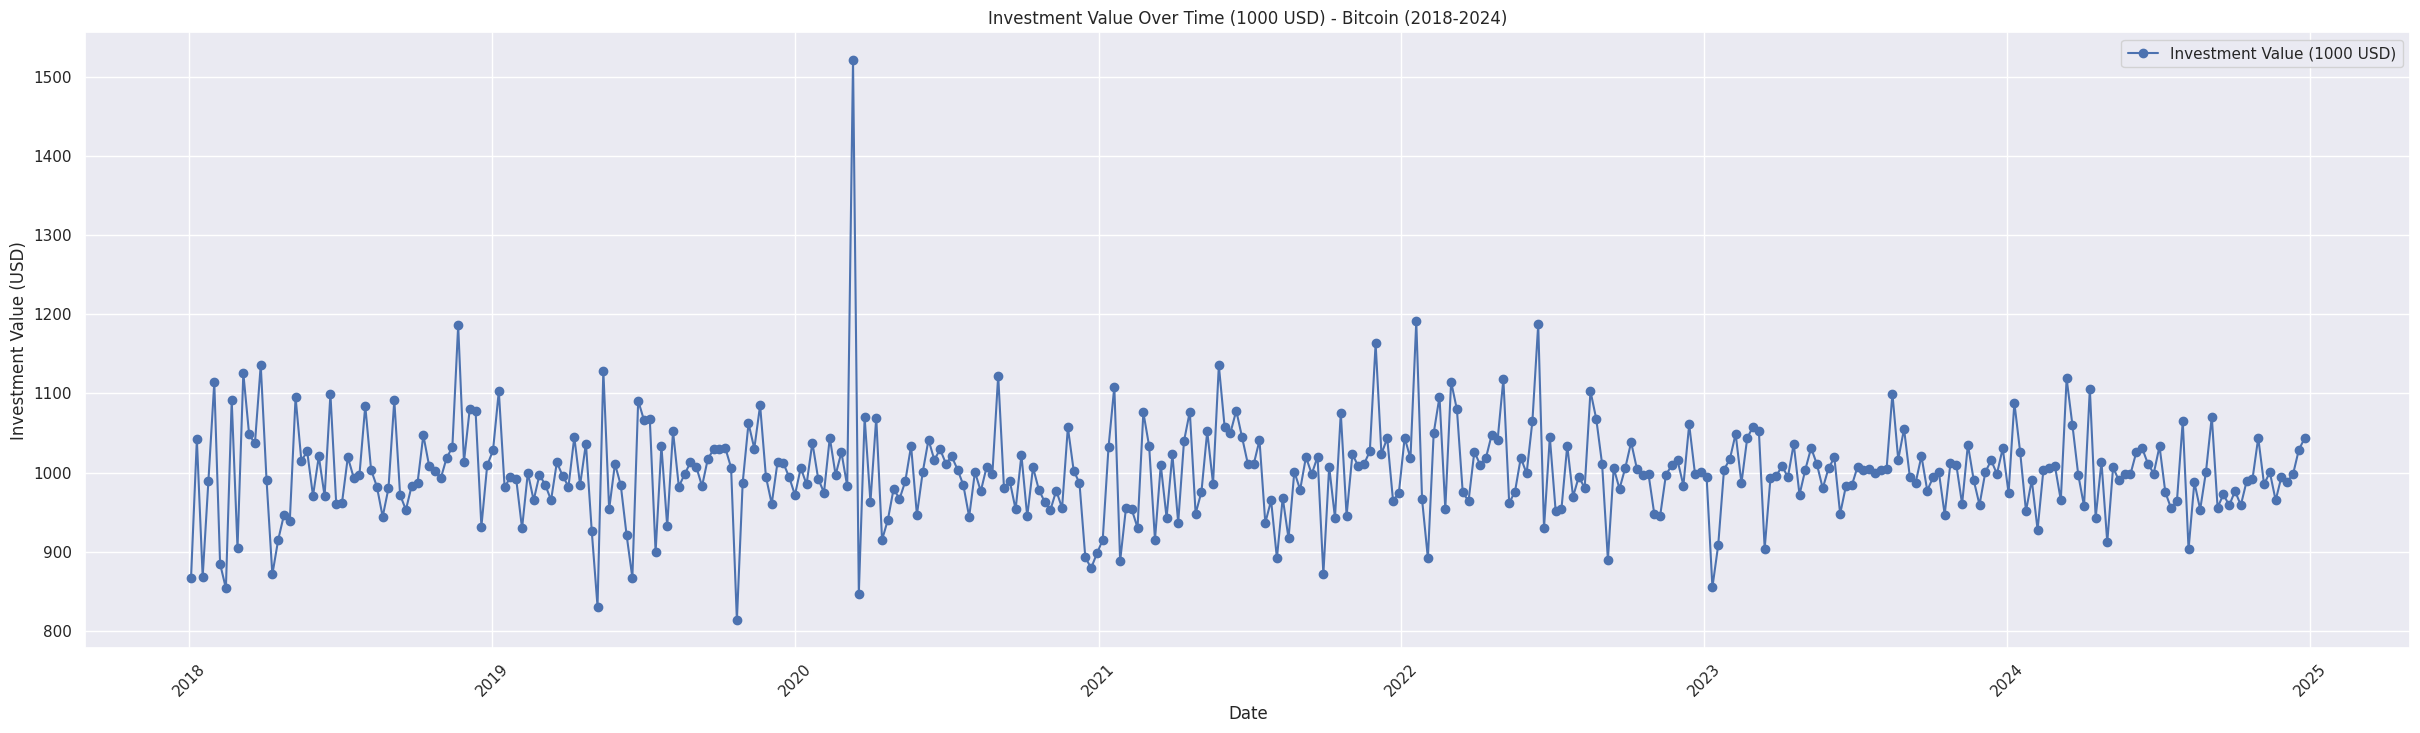

In [299]:
sns.set(style="darkgrid")
close_wed['Investment_Value'] = investment_value + [np.nan] * (len(close_wed) - len(investment_value))

plt.figure(figsize=(30, 8))
plt.plot(close_wed['Solar_Date'], close_wed['Investment_Value'], label="Investment Value (1000 USD)", color='b', marker='o', linestyle='-')
plt.title('Investment Value Over Time (1000 USD) - Bitcoin (2018-2024)')
plt.xlabel('Date')
plt.ylabel('Investment Value (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [300]:
open_sun['BTC Purchased'] = capital / open_sun[('Open', 'BTC-USD')]
open_sun['Capital Wed'] = open_sun['BTC Purchased'] * open_sun[('Wednesday Close', '')]

print(open_sun[['Open', 'Wednesday Close', 'BTC Purchased', 'Capital Wed']].head())
print(open_sun[['Open', 'Wednesday Close', 'BTC Purchased', 'Capital Wed']].info())

Price               Open Wednesday Close BTC Purchased Capital Wed
Ticker           BTC-USD                                          
Date                                                              
2018-01-07  17527.300781    14973.299805      0.057054  854.284363
2018-01-14  14370.799805    11188.599609      0.069586  778.564819
2018-01-21  12889.200195    11359.400391      0.077584  881.311523
2018-01-28  11475.299805    10221.099609      0.087144  890.704346
2018-02-04   9175.700195     7621.299805      0.108984  830.596008
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-07 to 2024-12-29
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Open, BTC-USD)      365 non-null    float32
 1   (Wednesday Close, )  364 non-null    float32
 2   (BTC Purchased, )    365 non-null    float32
 3   (Capital Wed, )      364 non-null    float32
dtypes: float32(4)
memory usage: 8.6 KB
N

In [301]:
final_capital = open_sun['Capital Wed'].iloc[::]
print(f"Final capital at the end of 2024: ${final_capital}")

Final capital at the end of 2024: $Date
2018-01-07     854.284363
2018-01-14     778.564819
2018-01-21     881.311523
2018-01-28     890.704346
2018-02-04     830.596008
                 ...     
2024-12-01    1023.918335
2024-12-08    1012.520935
2024-12-15     986.860596
2024-12-22    1021.404175
2024-12-29            NaN
Name: Capital Wed, Length: 365, dtype: float32


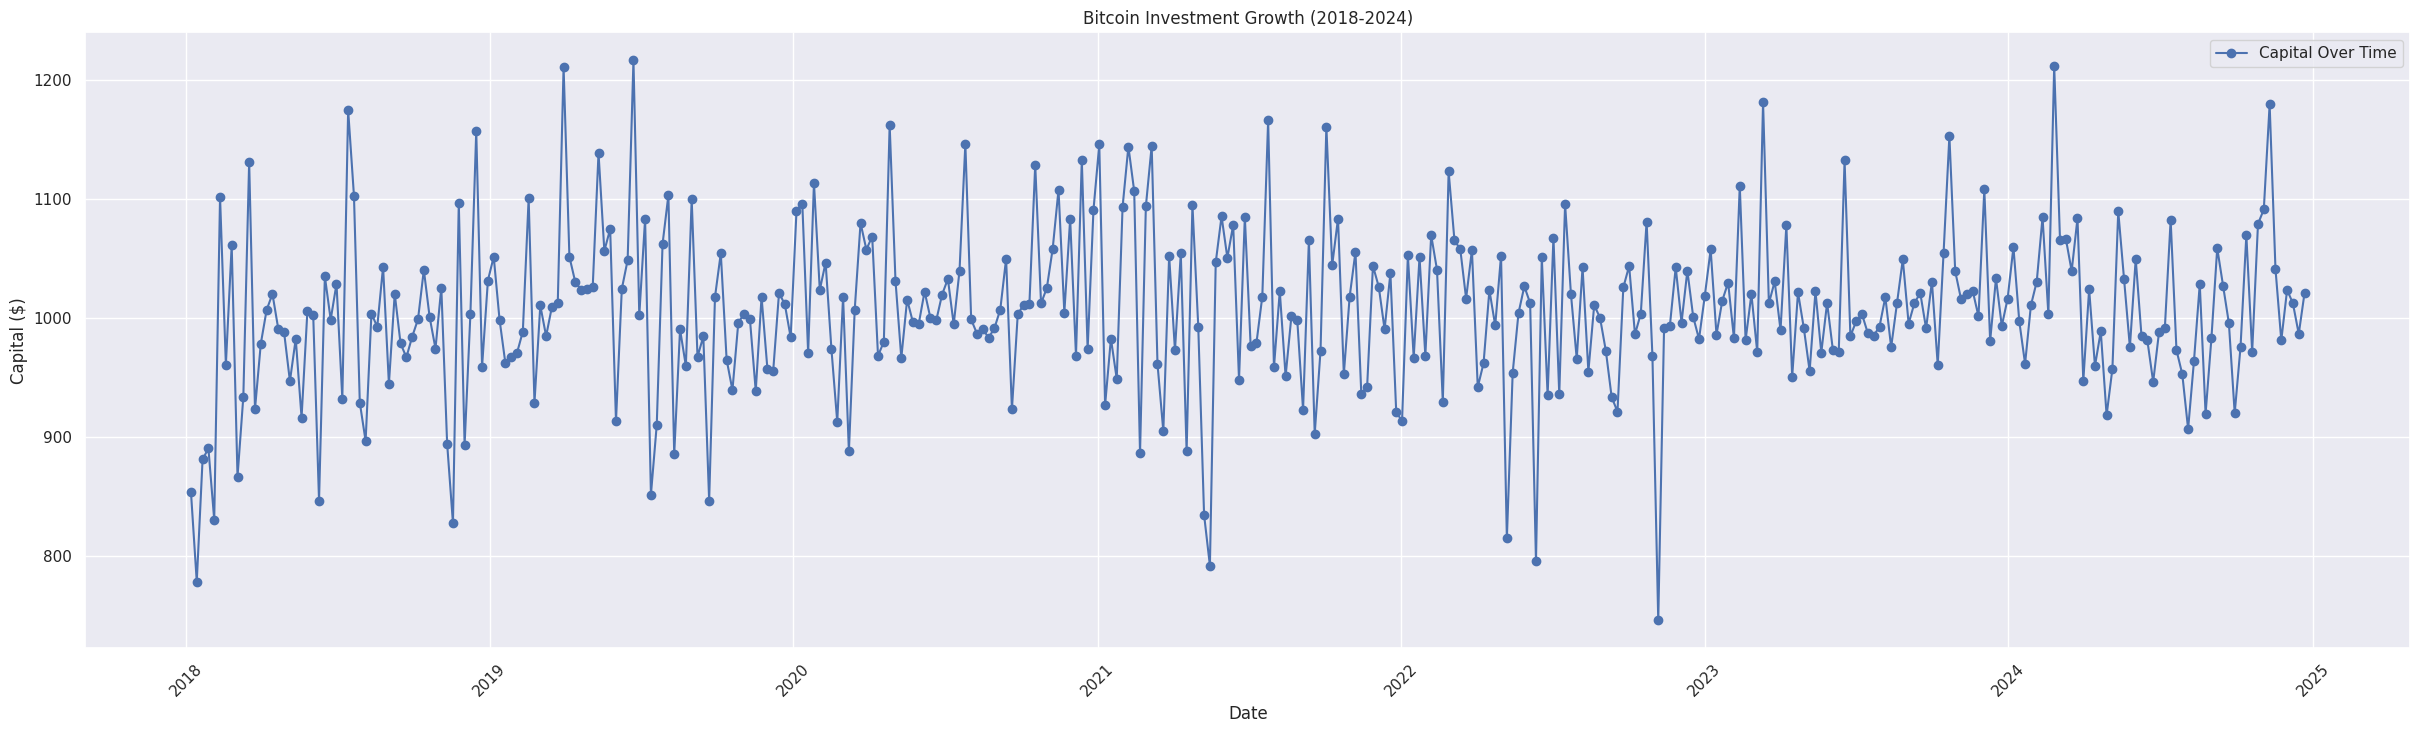

In [302]:
plt.figure(figsize=(30, 8))
plt.plot(open_sun.index, open_sun['Capital Wed'], marker='o', linestyle='-', color='b', label='Capital Over Time')
plt.xlabel("Date")
plt.ylabel("Capital ($)")
plt.title("Bitcoin Investment Growth (2018-2024)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

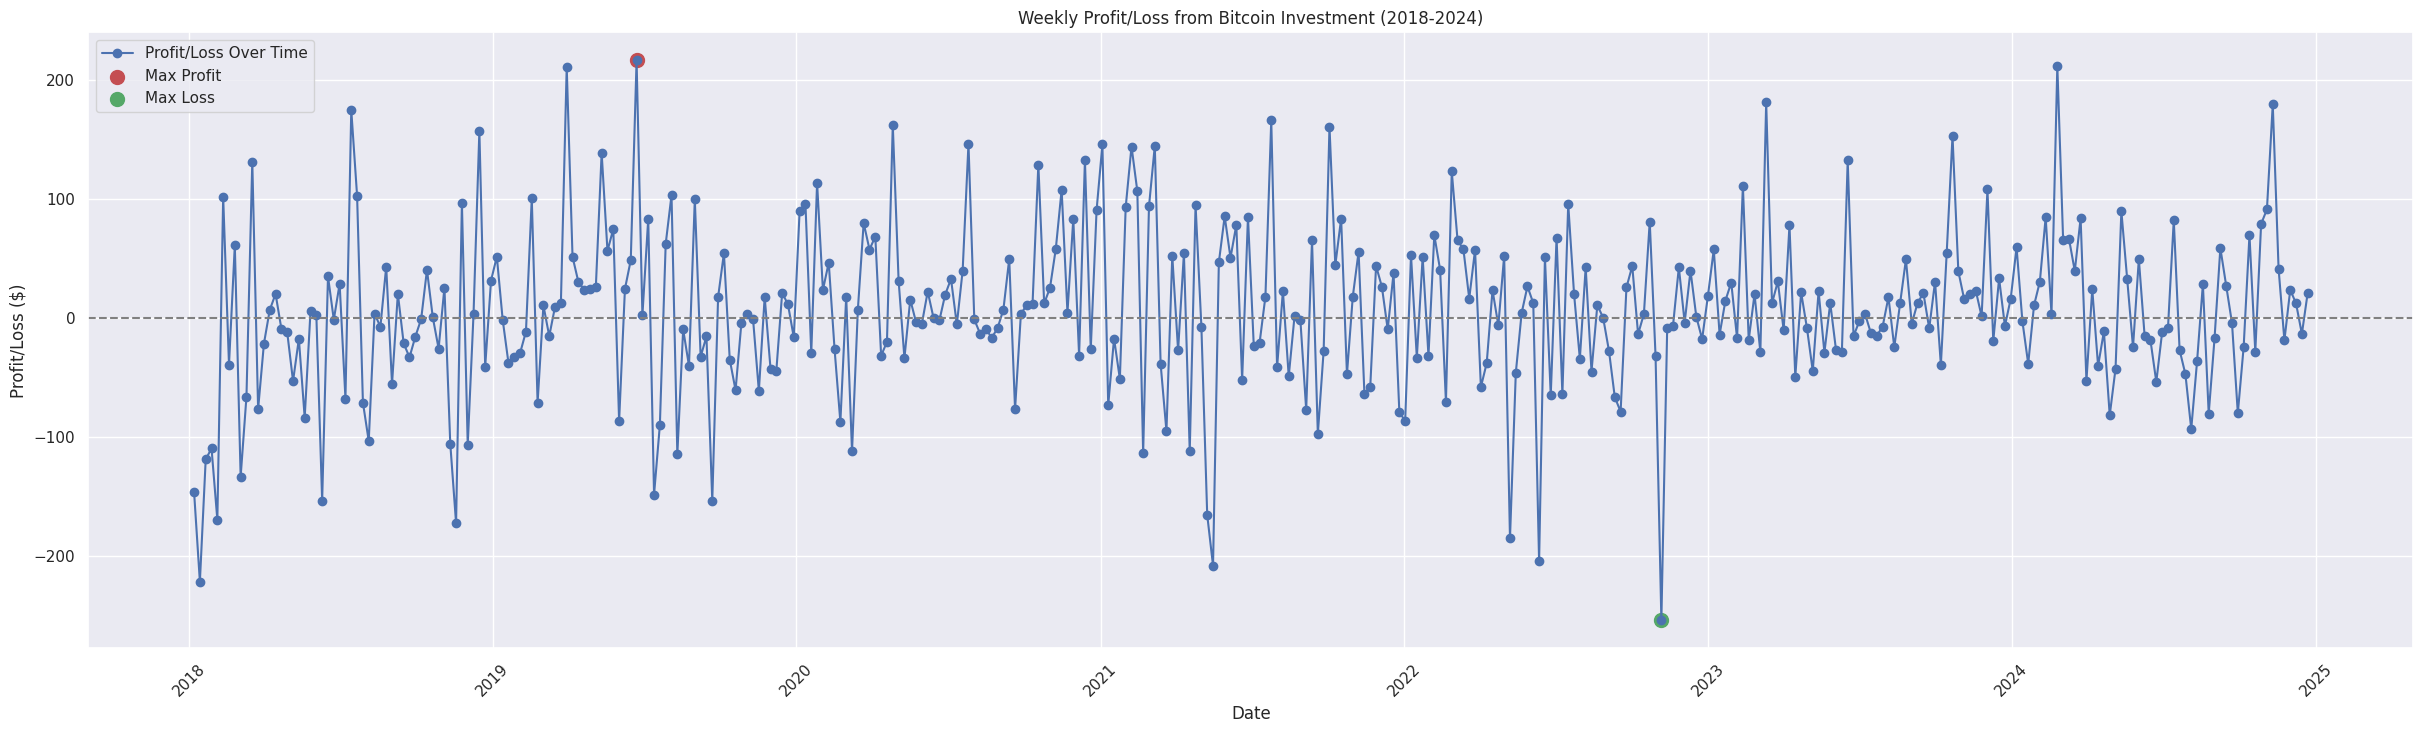

In [303]:
open_sun['Profit/Loss'] = (open_sun[('Wednesday Close', '')] - open_sun[('Open', 'BTC-USD')]) * open_sun['BTC Purchased']

open_sun['Profit/Loss'] = open_sun['Profit/Loss'].squeeze()

max_profit_idx = open_sun['Profit/Loss'].idxmax()
max_profit_value = open_sun.loc[max_profit_idx, 'Profit/Loss']

max_loss_idx = open_sun['Profit/Loss'].idxmin()
max_loss_value = open_sun.loc[max_loss_idx, 'Profit/Loss']

plt.figure(figsize=(30, 8))
plt.plot(open_sun.index, open_sun['Profit/Loss'], marker='o', linestyle='-', color='b', label='Profit/Loss Over Time')
plt.scatter(open_sun.index[open_sun.index.get_loc(max_profit_idx)], max_profit_value, color='r', s=100, label=f'Max Profit')
plt.scatter(open_sun.index[open_sun.index.get_loc(max_loss_idx)], max_loss_value, color='g', s=100, label=f'Max Loss')

plt.axhline(y=0, color='gray', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Profit/Loss ($)")
plt.title("Weekly Profit/Loss from Bitcoin Investment (2018-2024)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [304]:
max_profit_date = open_sun.loc[max_profit_idx, 'Solar_Date'].iloc[0] if isinstance(open_sun.loc[max_profit_idx, 'Solar_Date'], pd.Series) else open_sun.loc[max_profit_idx, 'Solar_Date']
max_loss_date = open_sun.loc[max_loss_idx, 'Solar_Date'].iloc[0] if isinstance(open_sun.loc[max_loss_idx, 'Solar_Date'], pd.Series) else open_sun.loc[max_loss_idx, 'Solar_Date']

max_profit_date = jdatetime.date.fromgregorian(date=max_profit_date).strftime('%Y-%m-%d')
max_loss_date = jdatetime.date.fromgregorian(date=max_loss_date).strftime('%Y-%m-%d')
print(f"The highest profit occurred in the week of {max_profit_date} with a value of {max_profit_value} USD.")
print(f"The highest loss occurred in the week of {max_loss_date} with a value of {max_loss_value} USD.")


The highest profit occurred in the week of 1398-04-02 with a value of Ticker
    216.846497
Name: 2019-06-23 00:00:00, dtype: object USD.
The highest loss occurred in the week of 1401-08-15 with a value of Ticker
   -253.900009
Name: 2022-11-06 00:00:00, dtype: object USD.


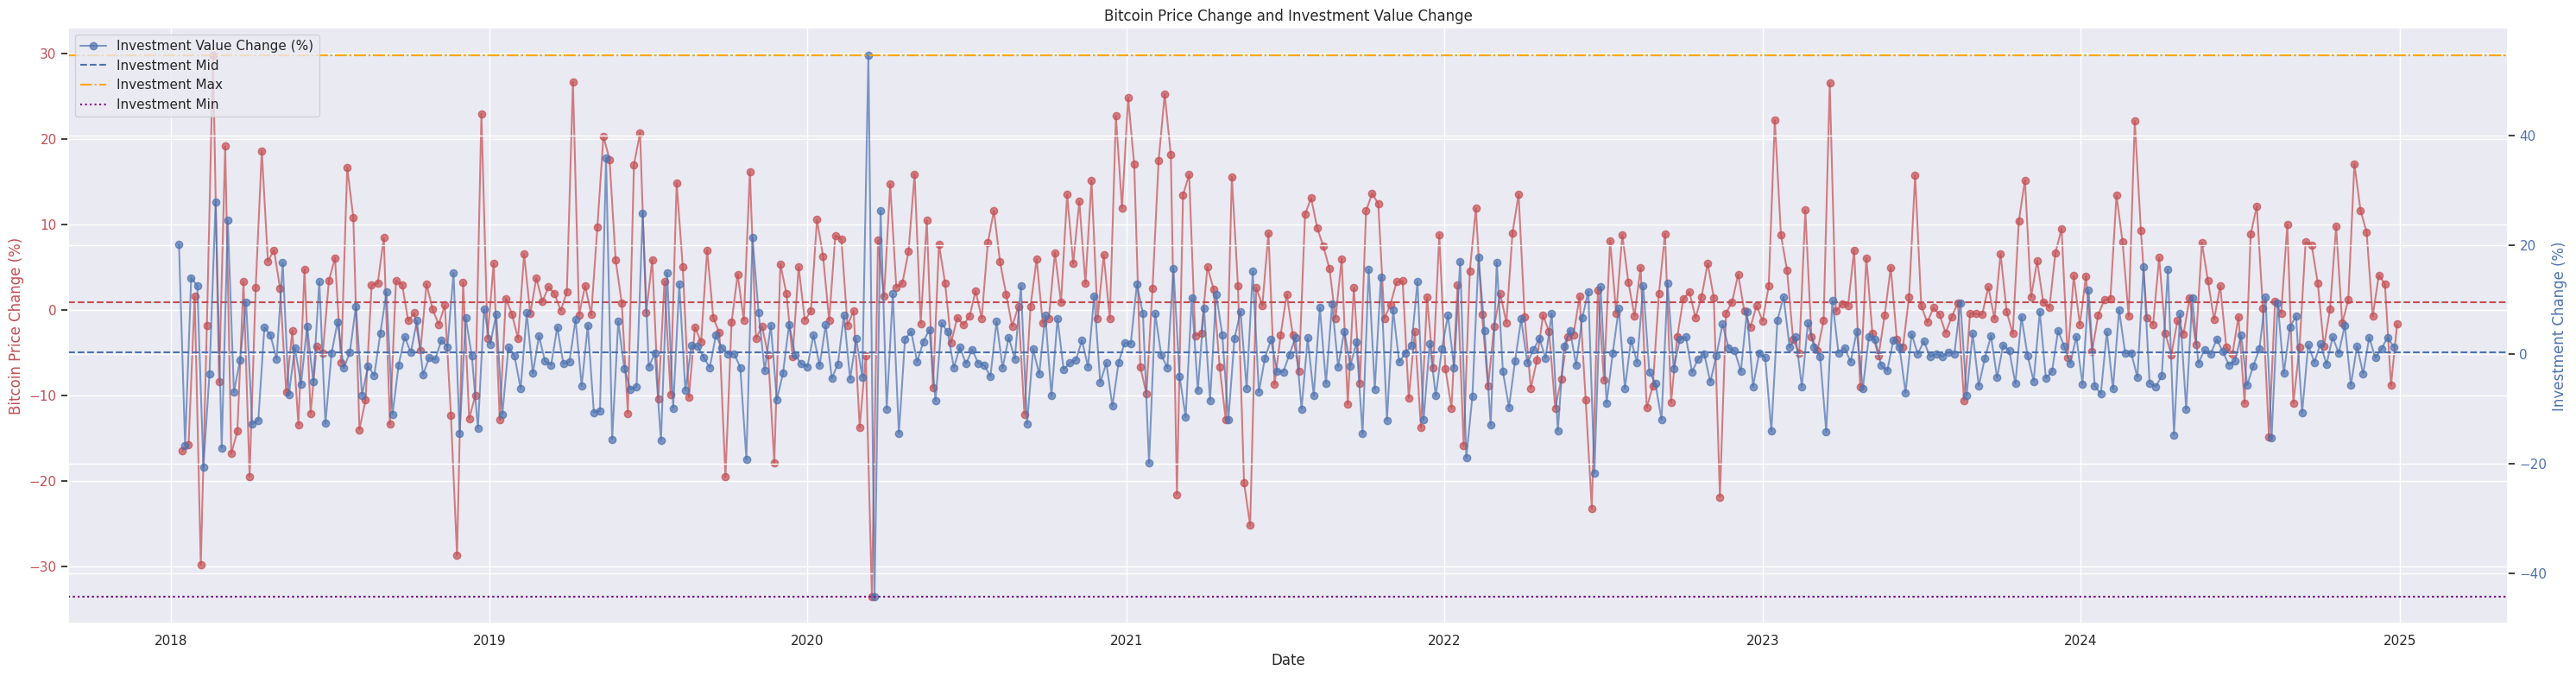

In [305]:
btc_weekly = btc.resample('W').last()
btc_weekly['Price_Change'] = btc_weekly['Close'].pct_change() * 100

investment_df = close_wed.copy()
investment_df['Investment_Value'] = investment_value + [np.nan] * (len(close_wed) - len(investment_value))

investment_df['Investment_Change'] = investment_df['Investment_Value'].pct_change() * 100

fig, ax1 = plt.subplots(figsize=(30, 8))

ax1.plot(btc_weekly.index, btc_weekly['Price_Change'], label="Bitcoin Price Change (%)", color='r', marker='o', linestyle='-', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price Change (%)', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_title('Bitcoin Price Change and Investment Value Change')

btc_mid = btc_weekly['Price_Change'].mean()
btc_max = btc_weekly['Price_Change'].max()
btc_min = btc_weekly['Price_Change'].min()
ax1.axhline(y=btc_mid, color='r', linestyle='--', label='Bitcoin Mid')
ax1.axhline(y=btc_max, color='g', linestyle='-.', label='Bitcoin Max')
ax1.axhline(y=btc_min, color='b', linestyle=':', label='Bitcoin Min')

ax2 = ax1.twinx()
ax2.plot(investment_df['Solar_Date'], investment_df['Investment_Change'], label="Investment Value Change (%)", color='b', marker='o', linestyle='-', alpha=0.7)
ax2.set_ylabel('Investment Change (%)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

investment_mid = investment_df['Investment_Change'].mean()
investment_max = investment_df['Investment_Change'].max()
investment_min = investment_df['Investment_Change'].min()
ax2.axhline(y=investment_mid, color='b', linestyle='--', label='Investment Mid')
ax2.axhline(y=investment_max, color='orange', linestyle='-.', label='Investment Max')
ax2.axhline(y=investment_min, color='purple', linestyle=':', label='Investment Min')

fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

<ipython-input-306-fc4c0264d610>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  btc_monthly = btc.resample('M').last()
<ipython-input-306-fc4c0264d610>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  investment_df = investment_df.resample('M', on='Solar_Date').last()


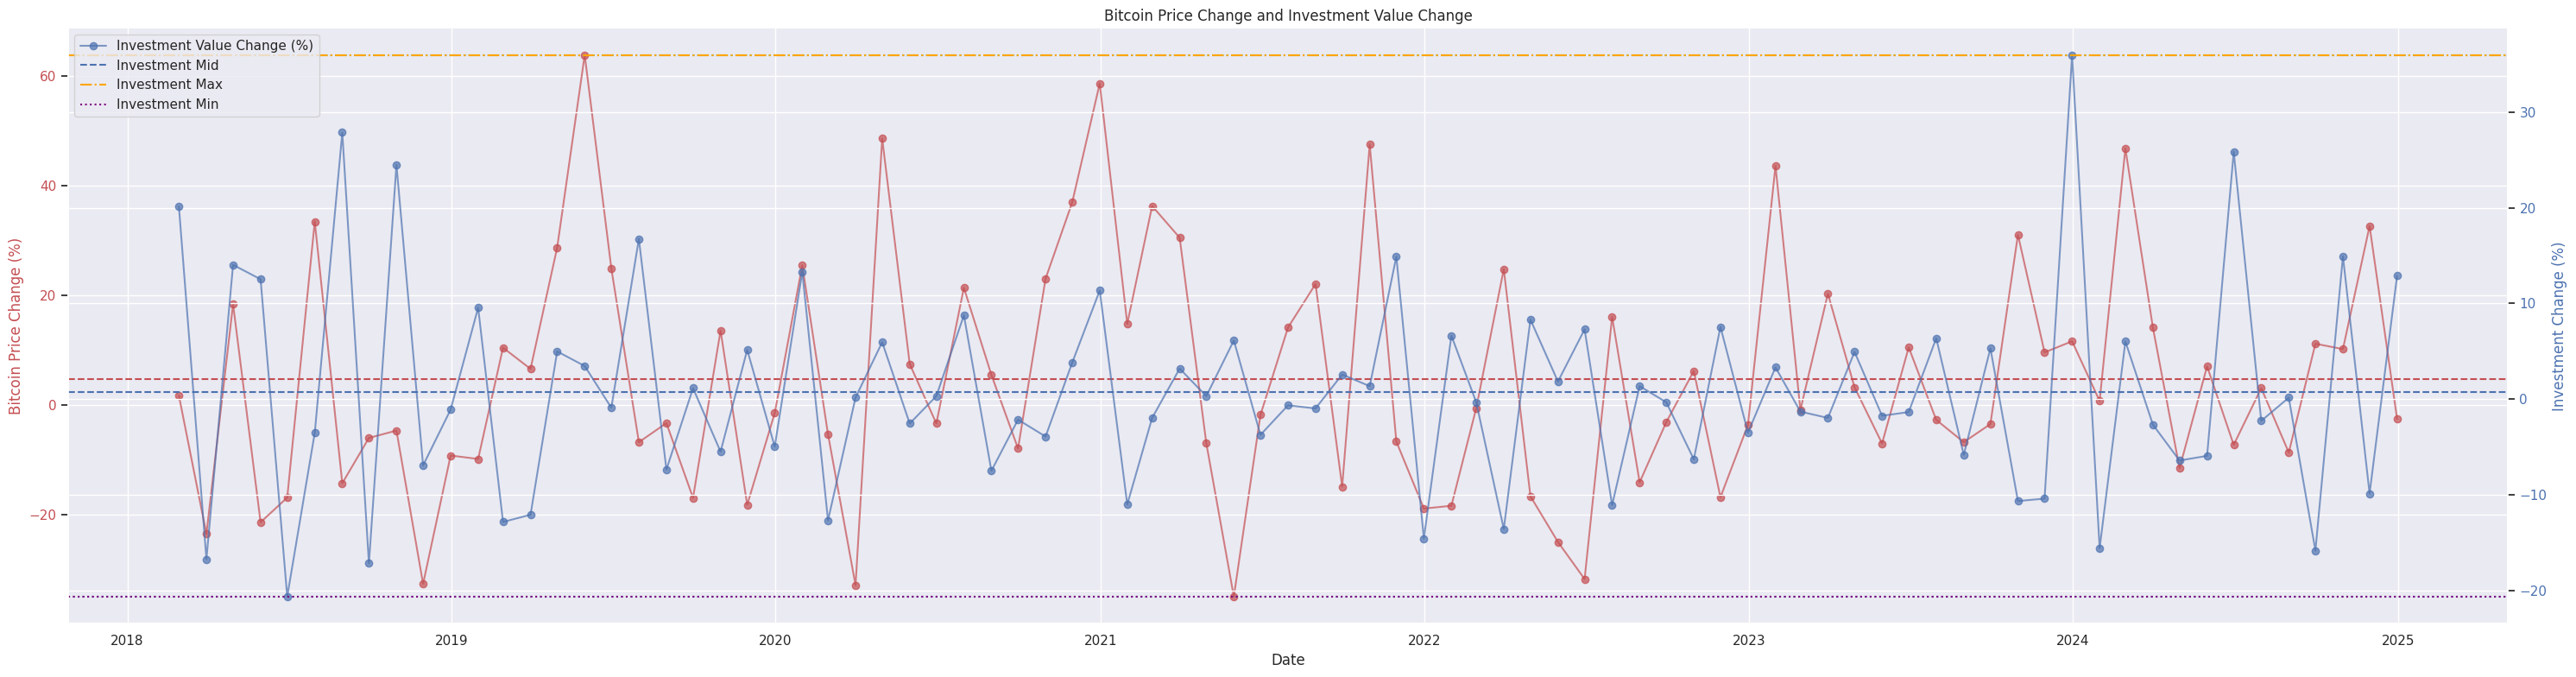

In [306]:
btc_monthly = btc.resample('M').last()
btc_monthly['Price_Change'] = btc_monthly['Close'].pct_change() * 100

investment_df = close_wed.copy()

investment_df = investment_df.resample('M', on='Solar_Date').last()
investment_df['Investment_Value'] = investment_value[:len(investment_df)]

investment_df['Investment_Change'] = investment_df['Investment_Value'].pct_change() * 100

fig, ax1 = plt.subplots(figsize=(30, 8))

ax1.plot(btc_monthly.index, btc_monthly['Price_Change'], label="Bitcoin Price Change (%)", color='r', marker='o', linestyle='-', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price Change (%)', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_title('Bitcoin Price Change and Investment Value Change')

btc_mid = btc_monthly['Price_Change'].mean()
btc_max = btc_monthly['Price_Change'].max()
btc_min = btc_monthly['Price_Change'].min()
ax1.axhline(y=btc_mid, color='r', linestyle='--', label='Bitcoin Mid')
ax1.axhline(y=btc_max, color='g', linestyle='-.', label='Bitcoin Max')
ax1.axhline(y=btc_min, color='b', linestyle=':', label='Bitcoin Min')

ax2 = ax1.twinx()
ax2.plot(investment_df.index, investment_df['Investment_Change'], label="Investment Value Change (%)", color='b', marker='o', linestyle='-', alpha=0.7)
ax2.set_ylabel('Investment Change (%)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

investment_mid = investment_df['Investment_Change'].mean()
investment_max = investment_df['Investment_Change'].max()
investment_min = investment_df['Investment_Change'].min()
ax2.axhline(y=investment_mid, color='b', linestyle='--', label='Investment Mid')
ax2.axhline(y=investment_max, color='orange', linestyle='-.', label='Investment Max')
ax2.axhline(y=investment_min, color='purple', linestyle=':', label='Investment Min')

fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()